In [ ]:
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap
import numpy as np
from pathlib import Path
import jax



import typing
import h5py
import pandas as pd
import numpy as np
import jax
import os
from jax import vmap
import blackjax
import jax.numpy as jnp
import jax.random as random
from jax import jit
from tabulate import tabulate
from dataclasses import dataclass
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpecFromSubplotSpec

# Change the used font to the same LaTeX uses for consistency
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import sys
import os

spec_df = pd.read_csv('/Users/amanda/Desktop/PhD/Tools/ceridwen/data/test_data/spectra.csv')
wave = jnp.array(spec_df['wave'])

In [70]:

def calzetti_jax(wave, tau_v=1.0, R_v=4.05, **kwargs):
    """Calzetti et al. 2000 starburst attenuation curve with FUV and NIR extrapolations.

    :param wave: array of wavelengths in Angstrom
    :param tau_v: optical depth at 5500 Å
    :param R_v: ratio of total to selective extinction
    :returns: optical depth at each wavelength
    """
    # Define k(lambda) functions
    def k1(x): return 2.659 * (-1.857 + 1.040 * x)
    def k2(x): return 2.659 * (-2.156 + 1.509 * x - 0.198 * x**2 + 0.011 * x**3)

    # Precompute reference slopes and normalization
    uv = jnp.array([0.12, 0.13]) * 1e4
    kuv = k2(1e4 / uv) + R_v
    uv_slope = (kuv[1] - kuv[0]) / (uv[1] - uv[0])

    ir = jnp.array([2.19, 2.20]) * 1e4
    kir = k1(1e4 / ir) + R_v
    ir_slope = (kir[1] - kir[0]) / (ir[1] - ir[0])

    k_v = k2(1e4 / 5500.0) + R_v

    print(uv, kuv, uv_slope)
    print(ir, kir, ir_slope)
    print(k_v)

    x = 1e4 / wave
    ktot = jnp.zeros_like(wave)

    # Define masks
    uinds = (wave >= 1200.0) & (wave < 6300.0)
    oinds = (wave >= 6300.0) & (wave <= 22000.0)
    xinds = wave < 1200.0
    iinds = wave > 22000.0

    # Construct ktot piecewise
    ktot = jnp.where(oinds, k1(x) + R_v, ktot)
    ktot = jnp.where(uinds, k2(x) + R_v, ktot)
    ktot = jnp.where(xinds, kuv[0] + (wave - uv[0]) * uv_slope, ktot)
    ktot = jnp.where(iinds, kir[1] + (wave - ir[1]) * ir_slope, ktot)

    # Ensure no negative attenuation
    ktot = jnp.maximum(ktot, 0.0)

    return tau_v * (ktot / k_v)


def calzetti(wave, tau_v=1, R_v=4.05, **kwargs):
    """Calzetti et al. 2000 starburst attenuation curve, with extrapolations to
    the FUV and NIR.

    :param wave:
        The wavelengths at which optical depth estimates are desired.

    :param tau_v: (default: 1)
        The optical depth at 5500\AA, used to normalize the attenuation curve.

    :param R_v: (default: 4.05)
        The ratio of total selective extinction, parameterizing the slope of
        the attenuation curve.  A_v = R_v * E(B-V)

    :returns tau:
        The optical depth at each wavelength.
    """
    # optical/NIR
    k1 = lambda x: 2.659 * (-1.857 + 1.040 * x)
    # UV
    k2 = lambda x: 2.659 * (-2.156 + 1.509 * x - 0.198 * x**2. + 0.011 * x**3.)

    # get slopes at edges and k(5500)
    uv = np.array([0.12, 0.13]) * 1e4
    kuv = k2(1e4 / uv) + R_v
    uv_slope = np.diff(kuv) / np.diff(uv)
    ir = np.array([2.19, 2.20]) * 1e4
    kir = k1(1e4 / ir) + R_v
    ir_slope = np.diff(kir) / np.diff(ir)
    k_v = k2(1e4 / 5500.) + R_v

    print(uv, kuv, uv_slope)
    print(ir, kir, ir_slope)
    print(k_v)

    # define segments
    uinds = (wave >= 1200.) & (wave < 6300)  # uv
    oinds = (wave >= 6300.) & (wave <= 22000)  # optical
    xinds = (wave < 1200.)  # xuv
    iinds = (wave > 22000.)  # ir

    # do it
    x = 1e4 / wave
    ktot = oinds * (k1(x) + R_v)
    ktot += uinds * (k2(x) + R_v)
    ktot += xinds * (kuv[0] + (wave - uv[0]) * uv_slope)
    ktot += iinds * (kir[1] + (wave - ir[1]) * ir_slope)

    ktot[ktot < 0] = 0
    tau_lambda = tau_v * (ktot / k_v)
    return tau_lambda


In [71]:
att_jax = calzetti_jax(wave=jnp.array(spec_df['wave']))
att = calzetti(wave=np.array(spec_df['wave']))

[1200. 1300.] [12.119371 11.342421] -0.0077695083
[21900. 22000.] [0.37495875 0.3692193 ] -5.7394504e-05
4.0478903801652875
[1200. 1300.] [12.11937563 11.34242308] [-0.00776953]
[21900. 22000.] [0.37495846 0.36921882] [-5.73964301e-05]
4.0478903801652875


(-100.0, 30000.0)

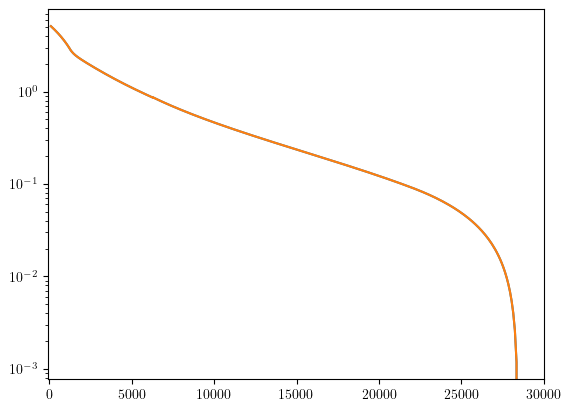

In [72]:
plt.plot(jnp.array(spec_df['wave']), att_jax)
plt.plot(jnp.array(spec_df['wave']), att)
plt.yscale('log')
plt.xlim(-100, 30000)



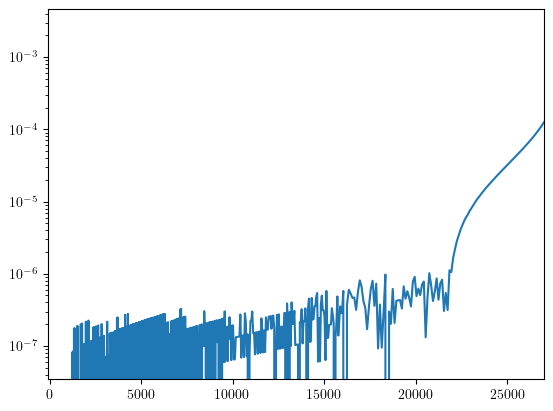

In [73]:
plt.plot(jnp.array(spec_df['wave']), (att_jax - att)/att)
plt.xlim(-100, 27000)
plt.yscale('log')

In [74]:

def drude(x, x0=4.59, gamma=0.90, **extras):
    """Drude profile for the 2175 Å bump.

    :param x:
        Inverse wavelength (inverse microns) at which values for the drude
        profile are requested.

    :param gamma:
        Width of the Drude profile (inverse microns).

    :param x0:
        Center of the Drude profile (inverse microns).

    :returns k_lambda:
        The value of the Drude profile at x, normalized such that the peak is 1.
    """
    return (x * gamma) ** 2 / ((x ** 2 - x0 ** 2) ** 2 + (x * gamma) ** 2)

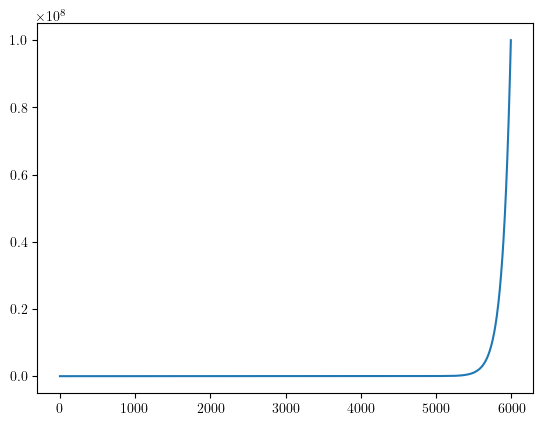

In [75]:
plt.plot(jnp.array(spec_df['wave']))

In [76]:
def noll_jax(wave, tau_v=1.0, delta=0.0, c_r=0.0, Ebump=0.0, **kwargs):
    """Noll 2009 attenuation curve (Calzetti + Drude bump + power-law tilt).

    :param wave: array of wavelengths in Ångström
    :param tau_v: V-band optical depth
    :param Ebump: bump strength (normalized Drude at 2175 Å)
    :param delta: slope of power-law modifying Calzetti
    :param c_r: constant modifying effective R_v (e.g., c_r = -delta)
    :returns: optical depth τ(λ)
    """
    # Calzetti baseline (normalized to τ_V = 1)
    kcalz = calzetti_jax(wave, tau_v=1.0, R_v=4.05) - 1.0
    
    # Drude bump at 2175 Å, input in inverse μm
    x = 1e4 / wave  # inverse microns
    bump = Ebump / 4.05 * drude(x, **kwargs)
    
    # Modified attenuation curve
    k = kcalz + bump
    a = (k * (1.0 - 1.12 * c_r) + 1.0) * (wave / 5500.0) ** delta
    return a * tau_v


def noll(wave, tau_v=1, delta=0.0, c_r=0.0, Ebump=0.0, **kwargs):
    """Noll 2009 attenuation curve. This is based on the Calzetti curve, with
    added variable bump (as Drude) and overall slope change.  Any extra
    keywords are passed to the Drude (e.g. x0, gamma, both in inverse microns).

    :param wave:
        The wavelengths at which optical depth estimates are desired.

    :param tau_v: (default: 1)
        The optical depth at 5500\AA, used to normalize the attenuation curve.

    :param Ebump: (default: 0.0)
        Stength of the 2175\AA bump.  Normalizes the Drude profile.

    :param delta: (default 0.)
        Slope of the power-law that modifies the Calzetti curve.

    :param c_r:
        Constant used to alter R_v=A_V/E(B-V) of the curve.  To maintain the
        Calzetti R_v=4.05, use c_r = -delta.  Note that even with c_r = -delta
        the calzetti curve will not be recovered unless delta=0

    :returns tau:
        The optical depth at each wavelength.
    """
    kcalz = calzetti(wave, tau_v=1.0, R_v=4.05) - 1
    k = kcalz + Ebump / 4.05 * drude(1e4 / wave, **kwargs)
    a = (k * (1 - 1.12 * c_r) + 1) * (wave / 5500.)**delta
    return a * tau_v

In [77]:
noll_jax = noll_jax(wave=jnp.array(spec_df['wave']))
noll = noll(wave=np.array(spec_df['wave']))

[1200. 1300.] [12.119371 11.342421] -0.0077695083
[21900. 22000.] [0.37495875 0.3692193 ] -5.7394504e-05
4.0478903801652875
[1200. 1300.] [12.11937563 11.34242308] [-0.00776953]
[21900. 22000.] [0.37495846 0.36921882] [-5.73964301e-05]
4.0478903801652875


(-100.0, 30000.0)

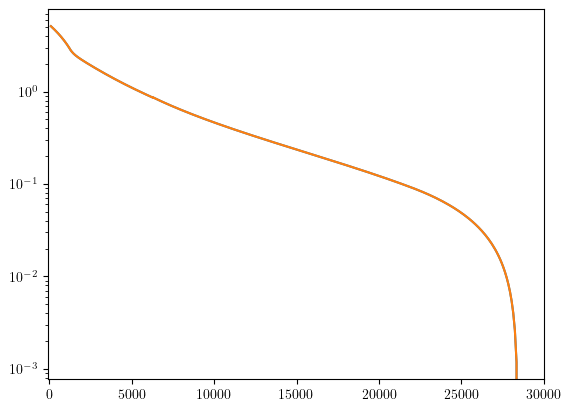

In [78]:
plt.plot(jnp.array(spec_df['wave']), noll_jax)
plt.plot(jnp.array(spec_df['wave']), noll)
plt.yscale('log')
plt.xlim(-100, 30000)

(-100.0, 30000.0)

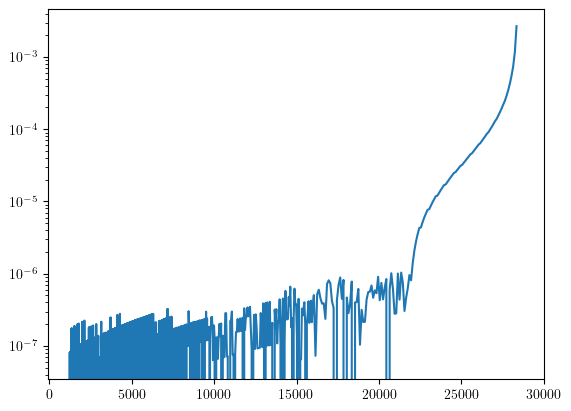

In [79]:
plt.plot(jnp.array(spec_df['wave']), (noll_jax - noll)/noll)
plt.yscale('log')
plt.xlim(-100, 30000)

In [80]:
def chevallard(wave, tau_v=1, **kwargs):
    """ \tau_v dependent attenuation curves matched to disk RT models,
    as in Chevallard et al. 2013.  No UV bump (or indeed tests in the
    UV at all).

    :param wave:
        The wavelengths at which optical depth estimates are desired.

    :param tau_v: (default: 1)
        The optical depth at 5500\AA, used to normalize the
        attenuation curve.

    :returns tau:
        The optical depth at each wavelength.
    """
    # missing a UV bump
    alpha_v = 2.8 / (1 + np.sqrt(tau_v))  # +/- 25%
    bb = 0.3 - 0.05 * tau_v  # +/- 10%
    alpha = alpha_v + bb * (wave * 1e-4 - 0.55)
    tau_lambda = tau_v * (wave / 5500.0)**(-alpha)
    return tau_lambda

def chevallard(wave, tau_v=1.0, **kwargs):
    """Chevallard et al. (2013) attenuation curve (disk RT-inspired, no UV bump).

    :param wave: Wavelengths in Ångström at which to evaluate optical depth.
    :param tau_v: Optical depth at 5500 Å.
    :returns: Optical depth at each wavelength.
    """
    alpha_v = 2.8 / (1.0 + jnp.sqrt(tau_v))  # Slope term
    bb = 0.3 - 0.05 * tau_v  # Slope modifier
    alpha = alpha_v + bb * (wave * 1e-4 - 0.55)  # Total slope
    tau_lambda = tau_v * (wave / 5500.0) ** (-alpha)
    return tau_lambda

chevallard_jax = chevallard(wave=jnp.array(spec_df['wave']))
chevallard = chevallard(wave=np.array(spec_df['wave']))

(-100.0, 50000.0)

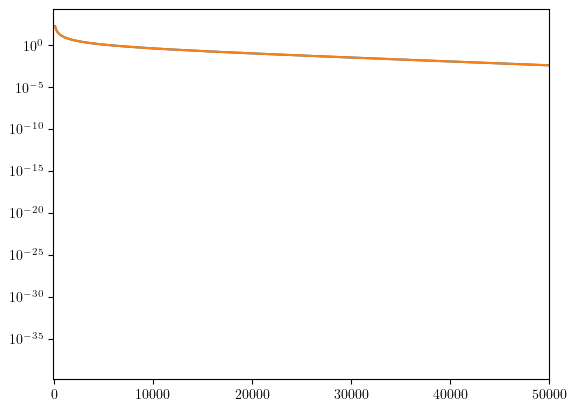

In [81]:
plt.plot(jnp.array(spec_df['wave']), chevallard_jax)
plt.plot(jnp.array(spec_df['wave']), chevallard)
plt.yscale('log')
plt.xlim(-100, 50000)

(-100.0, 30000.0)

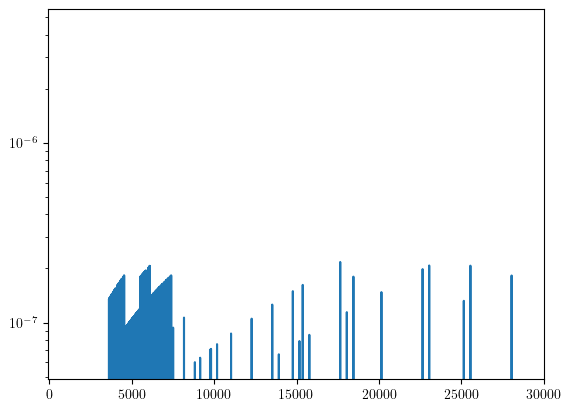

In [82]:
plt.plot(jnp.array(spec_df['wave']), (chevallard_jax - chevallard)/chevallard)
plt.yscale('log')
plt.xlim(-100, 30000)

# Conroy

In [91]:

def conroy_jax(wave, tau_v=1.0, R_v=3.1, f_bump=0.6, **kwargs):
    """Conroy & Schiminovich (2010) attenuation curve, including a reduced UV bump.

    :param wave: Wavelengths in Ångström
    :param tau_v: V-band optical depth
    :param R_v: Total-to-selective extinction ratio
    :param f_bump: UV bump strength relative to Cardelli
    :returns: Optical depth τ(λ)
    """
    x = 1e4 / wave  # inverse micron
    a = jnp.zeros_like(x)
    b = jnp.zeros_like(x)

    # IR (0.3 <= x < 1.1)
    ir = (x >= 0.3) & (x < 1.1)
    a_ir = 0.574 * x**1.61
    b_ir = -0.527 * x**1.61
    a = jnp.where(ir, a_ir, a)
    b = jnp.where(ir, b_ir, b)

    # Optical (1.1 <= x < 3.3)
    opt = (x >= 1.1) & (x < 3.3)
    y = x - 1.82
    y_opt = y
    a_opt = (1. + 0.177 * y_opt - 0.504 * y_opt**2 - 0.0243 * y_opt**3 +
             0.721 * y_opt**4 + 0.0198 * y_opt**5 - 0.7750 * y_opt**6 +
             0.330 * y_opt**7)
    b_opt = (1.413 * y_opt + 2.283 * y_opt**2 + 1.072 * y_opt**3 -
             5.384 * y_opt**4 - 0.622 * y_opt**5 + 5.303 * y_opt**6 -
             2.090 * y_opt**7)
    a = jnp.where(opt, a_opt, a)
    b = jnp.where(opt, b_opt, b)

    # NUV (3.3 <= x < 5.9)
    nuv = (x >= 3.3) & (x < 5.9)
    tmp = (-0.0370 + 0.0469 * f_bump - 0.601 * f_bump / R_v + 0.542 / R_v)
    fa_nuv = (3.3 / x)**6 * tmp
    tmp1 = 0.104 * f_bump / ((x - 4.67)**2 + 0.341)
    a_nuv = 1.752 - 0.316 * x - tmp1 + fa_nuv
    tmp2 = 1.206 * f_bump / ((x - 4.62)**2 + 0.263)
    b_nuv = -3.09 + 1.825 * x + tmp2
    a = jnp.where(nuv, a_nuv, a)
    b = jnp.where(nuv, b_nuv, b)

    # FUV (5.9 <= x < 8.0)
    fuv = (x >= 5.9) & (x < 8.0)
    dx = x - 5.9
    fa_fuv = -0.0447 * dx**2 - 0.00978 * dx**3
    fb_fuv = 0.213 * dx**2 + 0.121 * dx**3
    tmp1 = 0.104 * f_bump / ((x - 4.67)**2 + 0.341)
    tmp2 = 1.206 * f_bump / ((x - 4.62)**2 + 0.263)
    a_fuv = 1.752 - 0.316 * x - tmp1 + fa_fuv
    b_fuv = -3.09 + 1.825 * x + tmp2 + fb_fuv
    a = jnp.where(fuv, a_fuv, a)
    b = jnp.where(fuv, b_fuv, b)

    # Main attenuation law
    alam = a + b / R_v

    # XUV (x >= 8.0)
    xuv = x >= 8.0
    x8 = 8.0
    dx8 = x8 - 5.9
    fa = -0.0447 * dx8**2 - 0.00978 * dx8**3
    fb = 0.213 * dx8**2 + 0.121 * dx8**3
    tmp1 = 0.104 * f_bump / ((x8 - 4.67)**2 + 0.341)
    tmp2 = 1.206 * f_bump / ((x8 - 4.62)**2 + 0.263)
    af = 1.752 - 0.316 * x8 - tmp1 + fa
    bf = -3.09 + 1.825 * x8 + tmp2 + fb
    a8 = af + bf / R_v
    alam = jnp.where(xuv, (x8 / x)**(-1.3) * a8, alam)

    return tau_v * alam

def conroy(wave, tau_v=1.0, R_v=3.1, f_bump=0.6, **kwargs):
    """Conroy & Schiminovich (2010) attenuation curve, including a reduced UV bump.

    :param wave: Wavelengths in Ångström
    :param tau_v: V-band optical depth
    :param R_v: Total-to-selective extinction ratio
    :param f_bump: UV bump strength relative to Cardelli
    :returns: Optical depth τ(λ)
    """
    x = 1e4 / wave  # inverse micron
    a = jnp.zeros_like(x)
    b = jnp.zeros_like(x)

    # IR (0.3 <= x < 1.1)
    ir = (x >= 0.3) & (x < 1.1)
    a_ir = 0.574 * x**1.61
    b_ir = -0.527 * x**1.61
    a = jnp.where(ir, a_ir, a)
    b = jnp.where(ir, b_ir, b)

    # Optical (1.1 <= x < 3.3)
    opt = (x >= 1.1) & (x < 3.3)
    y = x - 1.82
    y_opt = y
    a_opt = (1. + 0.177 * y_opt - 0.504 * y_opt**2 - 0.0243 * y_opt**3 +
             0.721 * y_opt**4 + 0.0198 * y_opt**5 - 0.7750 * y_opt**6 +
             0.330 * y_opt**7)
    b_opt = (1.413 * y_opt + 2.283 * y_opt**2 + 1.072 * y_opt**3 -
             5.384 * y_opt**4 - 0.622 * y_opt**5 + 5.303 * y_opt**6 -
             2.090 * y_opt**7)
    a = jnp.where(opt, a_opt, a)
    b = jnp.where(opt, b_opt, b)

    # NUV (3.3 <= x < 5.9)
    nuv = (x >= 3.3) & (x < 5.9)
    tmp = (-0.0370 + 0.0469 * f_bump - 0.601 * f_bump / R_v + 0.542 / R_v)
    fa_nuv = (3.3 / x)**6 * tmp
    tmp1 = 0.104 * f_bump / ((x - 4.67)**2 + 0.341)
    a_nuv = 1.752 - 0.316 * x - tmp1 + fa_nuv
    tmp2 = 1.206 * f_bump / ((x - 4.62)**2 + 0.263)
    b_nuv = -3.09 + 1.825 * x + tmp2
    a = jnp.where(nuv, a_nuv, a)
    b = jnp.where(nuv, b_nuv, b)

    # FUV (5.9 <= x < 8.0)
    fuv = (x >= 5.9) & (x < 8.0)
    dx = x - 5.9
    fa_fuv = -0.0447 * dx**2 - 0.00978 * dx**3
    fb_fuv = 0.213 * dx**2 + 0.121 * dx**3
    tmp1 = 0.104 * f_bump / ((x - 4.67)**2 + 0.341)
    tmp2 = 1.206 * f_bump / ((x - 4.62)**2 + 0.263)
    a_fuv = 1.752 - 0.316 * x - tmp1 + fa_fuv
    b_fuv = -3.09 + 1.825 * x + tmp2 + fb_fuv
    a = jnp.where(fuv, a_fuv, a)
    b = jnp.where(fuv, b_fuv, b)

    # Main attenuation law
    alam = a + b / R_v

    # XUV (x >= 8.0)
    xuv = x >= 8.0
    x8 = 8.0
    dx8 = x8 - 5.9
    fa = -0.0447 * dx8**2 - 0.00978 * dx8**3
    fb = 0.213 * dx8**2 + 0.121 * dx8**3
    tmp1 = 0.104 * f_bump / ((x8 - 4.67)**2 + 0.341)
    tmp2 = 1.206 * f_bump / ((x8 - 4.62)**2 + 0.263)
    af = 1.752 - 0.316 * x8 - tmp1 + fa
    bf = -3.09 + 1.825 * x8 + tmp2 + fb
    a8 = af + bf / R_v
    alam = jnp.where(xuv, (x8 / x)**(-1.3) * a8, alam)

    return tau_v * alam



In [92]:
conroy_jax = conroy_jax(wave)
conroy = conroy(wave)

(-100.0, 30000.0)

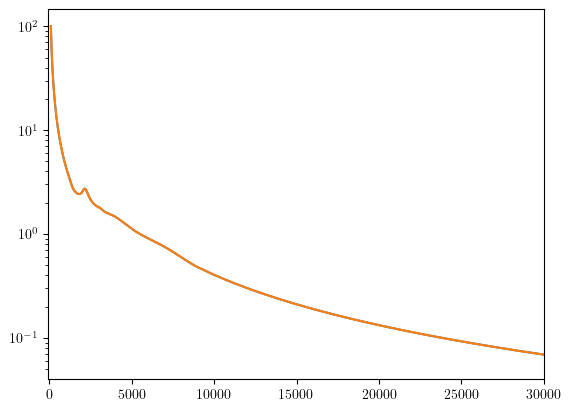

In [93]:
plt.plot(wave, conroy_jax)
plt.plot(wave, conroy)
plt.yscale('log')
plt.xlim(-100, 30000)

(-100.0, 30000.0)

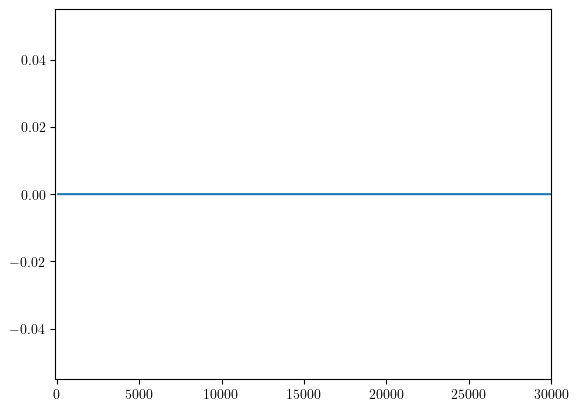

In [95]:
plt.plot(wave, (conroy_jax - conroy)/conroy)

plt.xlim(-100, 30000)

# Cardelli

In [110]:


def cardelli(wave, tau_v=1, R_v=3.1, **kwargs):
    """ Cardelli, Clayton, and Mathis 1998 Milky Way extinction curve,
    with an update in the near-UV from O'Donnell 1994

    :param wave:
        The wavelengths at which optical depth estimates are desired.

    :param tau_v: (default: 1)
        The optical depth at 5500\AA, used to normalize the
        attenuation curve.

    :param R_v: (default: 3.1)
        The ratio of total selective extinction, parameterizing the
        slope of the attenuation curve.  A_v = R_v * E(B-V)

    :returns tau:
        The optical depth at each wavelength.
    """
    # if (wave < 1e3).any() :
    #     warnings.warn('Cardelli: extinction not defined (set to zero) below 1000AA')
    mic = wave*1e-4
    x_sup, x_inf = 10.0, 0.3
    x = 1 / mic
    a = np.zeros_like(x)
    b = np.zeros_like(x)

    w1 = (x >= 1.1) & (x <= 3.3)  # Optical 0.303 to 0.909 micron
    w2 = (x >= x_inf) & (x < 1.1)  # NIR 0.909 to 3.3 micron
    w3 = (x > 3.3) & (x <= 8)  # UV 0.125 - 0.303 micron
    w4 = (x > 8.0) & (x <= x_sup)  # XUV, 1000 -1250AA
    wsh = x > x_sup
    wlg = x < x_inf

    y = x[w1] - 1.82
    a[w1] = (1 + 0.17699 * y - 0.50447 * y**2. - 0.02427 * y**3. +
             0.72085 * y**4. + 0.01979 * y**5. - 0.77530 * y**6. +
             0.32999 * y**7.0)
    b[w1] = (1.41338 * y + 2.28305 * y**2. + 1.07233 * y**3. -
             5.38434 * y**4. - 0.62251 * y**5. + 5.30260 * y**6. -
             2.09002 * y**7.)

    y = x[w2]**1.61
    a[w2] = 0.574 * y
    b[w2] = -0.527 * y

    fa = x[w3] * 0.
    fb = x[w3] * 0.
    ou = (x[w3] > 5.9)
    # print(type(ou),ou[0], type(w3))

    if ou.any():
        y = x[w3][ou] - 5.9
        fa[ou] = -0.04473 * y**2. - 0.009779 * y**3.
        fb[ou] = 0.2130 * y**2. + 0.1207 * y**3.
    a[w3] = 1.752 - 0.316 * x[w3] - 0.104 / ((x[w3] - 4.67)**2. + 0.341) + fa
    b[w3] = -3.090 + 1.825 * x[w3] + 1.206 / ((x[w3] - 4.62)**2. + 0.263) + fb

    y = x[w4] - 8.
    a[w4] = -1.073 - 0.628 * y + 0.137 * y**2. - 0.070 * y**3.
    b[w4] = 13.670 + 4.257 * y - 0.420 * y**2. + 0.374 * y**3.

    tau = a + b / R_v
    return tau_v * tau



def cardelli_jax(wave, tau_v=1.0, R_v=3.1, **kwargs):
    """Cardelli, Clayton, & Mathis (1989) extinction curve with O'Donnell (1994) UV update.

    :param wave: Wavelengths in Ångström
    :param tau_v: Optical depth at 5500 Å
    :param R_v: Total-to-selective extinction ratio
    :returns: Optical depth τ(λ)
    """
    mic = wave * 1e-4  # Convert to microns
    x = 1.0 / mic
    a = jnp.zeros_like(x)
    b = jnp.zeros_like(x)

    # Define wavelength ranges
    w1 = (x >= 1.1) & (x <= 3.3)   # Optical
    w2 = (x >= 0.3) & (x < 1.1)    # NIR
    w3 = (x > 3.3) & (x <= 8.0)    # UV
    w4 = (x > 8.0) & (x <= 10.0)   # FUV
    wsh = x > 10.0                 # Too short
    wlg = x < 0.3                  # Too long

    # Optical: 1.1 <= x <= 3.3
    y = x - 1.82
    a_w1 = (1. + 0.17699 * y - 0.50447 * y**2 - 0.02427 * y**3 +
            0.72085 * y**4 + 0.01979 * y**5 - 0.77530 * y**6 +
            0.32999 * y**7)
    b_w1 = (1.41338 * y + 2.28305 * y**2 + 1.07233 * y**3 -
            5.38434 * y**4 - 0.62251 * y**5 + 5.30260 * y**6 -
            2.09002 * y**7)
    a = jnp.where(w1, a_w1, a)
    b = jnp.where(w1, b_w1, b)

    # NIR: x < 1.1
    y = x**1.61
    a_w2 = 0.574 * y
    b_w2 = -0.527 * y
    a = jnp.where(w2, a_w2, a)
    b = jnp.where(w2, b_w2, b)

    # UV: 3.3 < x <= 8.0
    fa = jnp.zeros_like(x)
    fb = jnp.zeros_like(x)
    ou = (x > 5.9) & w3
    y_ou = x - 5.9
    fa_ou = -0.04473 * y_ou**2 - 0.009779 * y_ou**3
    fb_ou = 0.2130 * y_ou**2 + 0.1207 * y_ou**3
    fa = jnp.where(ou, fa_ou, 0.0)
    fb = jnp.where(ou, fb_ou, 0.0)
    a_w3 = 1.752 - 0.316 * x - 0.104 / ((x - 4.67)**2 + 0.341) + fa
    b_w3 = -3.090 + 1.825 * x + 1.206 / ((x - 4.62)**2 + 0.263) + fb
    a = jnp.where(w3, a_w3, a)
    b = jnp.where(w3, b_w3, b)

    # FUV: 8.0 < x <= 10.0
    y = x - 8.0
    a_w4 = -1.073 - 0.628 * y + 0.137 * y**2 - 0.070 * y**3
    b_w4 = 13.670 + 4.257 * y - 0.420 * y**2 + 0.374 * y**3
    a = jnp.where(w4, a_w4, a)
    b = jnp.where(w4, b_w4, b)

    # Final optical depth curve
    tau = a + b / R_v
    tau = jnp.where(wsh | wlg, 0.0, tau)  # Zero out outside valid range

    return tau_v * tau

In [111]:
cardelli_jax = cardelli_jax(wave=jnp.array(spec_df['wave']))
cardelli = cardelli(wave=np.array(spec_df['wave']))


(-100.0, 30000.0)

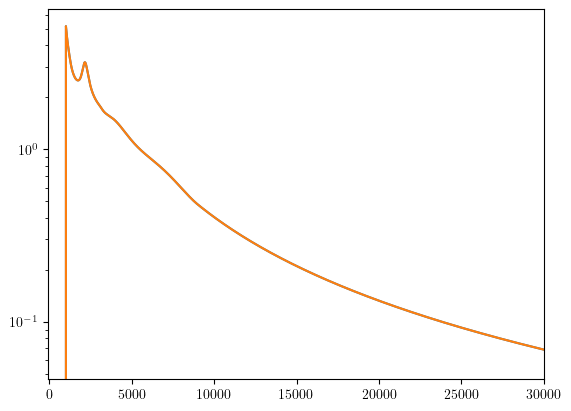

In [112]:

plt.plot(jnp.array(spec_df['wave']), cardelli_jax)
plt.plot(jnp.array(spec_df['wave']), cardelli)
plt.yscale('log')
plt.xlim(-100, 30000)

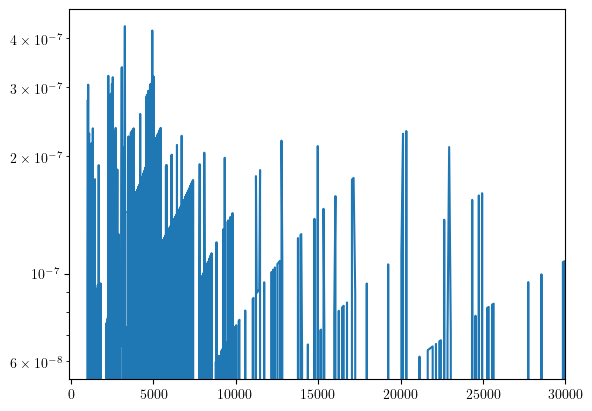

In [113]:
plt.plot(jnp.array(spec_df['wave']), (cardelli_jax - cardelli)/cardelli)
plt.xlim(-100, 30000)
plt.yscale('log')

# SMC

In [115]:

import warnings

def smc(wave, tau_v=1, **kwargs):
    """Pei 1992 SMC extinction curve.

    :param wave:
        The wavelengths at which optical depth estimates are desired.

    :param tau_v: (default: 1)
        The optical depth at 5500\AA, used to normalize the
        attenuation curve.

    :returns tau:
        The optical depth at each wavelength.
    """
    if (wave < 1e3).any():
        warnings.warn('SMC: extinction extrapolation below 1000AA is poor')
    mic = wave * 1e-4
    aa = [185.,  27.,  0.005, 0.010, 0.012, 0.030]
    ll = [0.042, 0.08, 0.22,  9.7,   18.,   25.]
    bb = [90.,   5.50, -1.95, -1.95, -1.80, 0.00]
    nn = [2.0,   4.0,  2.0,   2.0,   2.0,   2.0]

    abs_ab = np.zeros_like(mic)
    norm_v = 0  # hack to go from tau_b to tau_v
    mic_5500 = 5500 * 1e-4

    for i, a in enumerate(aa):
        norm_v += aa[i] / ((mic_5500 / ll[i])**nn[i] +
                           (ll[i] / mic_5500)**nn[i] + bb[i])
        abs_ab += aa[i] / ((mic / ll[i])**nn[i] + (ll[i] / mic)**nn[i] + bb[i])

    return tau_v * (abs_ab / norm_v)


def smc_jax(wave, tau_v=1.0, **kwargs):
    """Pei (1992) SMC extinction curve.

    :param wave: Wavelengths in Ångström
    :param tau_v: Optical depth at 5500 Å
    :returns: Optical depth τ(λ)
    """
    mic = wave * 1e-4  # Convert to microns
    aa = jnp.array([185., 27., 0.005, 0.010, 0.012, 0.030])
    ll = jnp.array([0.042, 0.08, 0.22, 9.7, 18., 25.])
    bb = jnp.array([90., 5.50, -1.95, -1.95, -1.80, 0.00])
    nn = jnp.array([2.0, 4.0, 2.0, 2.0, 2.0, 2.0])

    abs_ab = jnp.zeros_like(mic)
    norm_v = 0.0
    mic_5500 = 5500.0 * 1e-4  # Microns at 5500Å

    for i in range(len(aa)):
        norm_term = aa[i] / ((mic_5500 / ll[i])**nn[i] + (ll[i] / mic_5500)**nn[i] + bb[i])
        abs_term = aa[i] / ((mic / ll[i])**nn[i] + (ll[i] / mic)**nn[i] + bb[i])
        norm_v += norm_term
        abs_ab += abs_term

    return tau_v * (abs_ab / norm_v)


In [116]:
smc_jax = smc_jax(wave=jnp.array(spec_df['wave']))
smc = smc(wave=np.array(spec_df['wave']))

/var/folders/vd/kv9mg1cx6tdfwmlfx2m5qfr80000gp/T/ipykernel_92271/2123661438.py:17: UserWarning: SMC: extinction extrapolation below 1000AA is poor
  warnings.warn('SMC: extinction extrapolation below 1000AA is poor')


(-100.0, 30000.0)

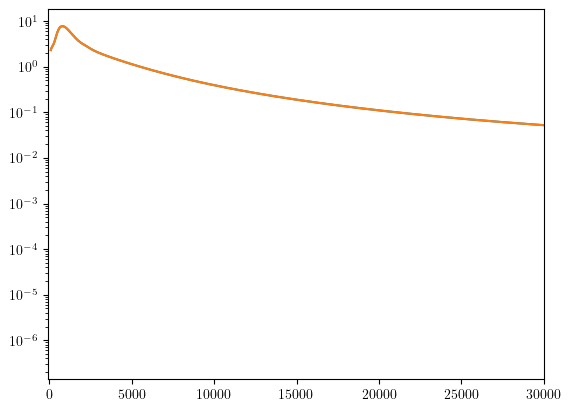

In [117]:
plt.plot(jnp.array(spec_df['wave']), smc_jax)
plt.plot(jnp.array(spec_df['wave']), smc)
plt.yscale('log')
plt.xlim(-100, 30000)

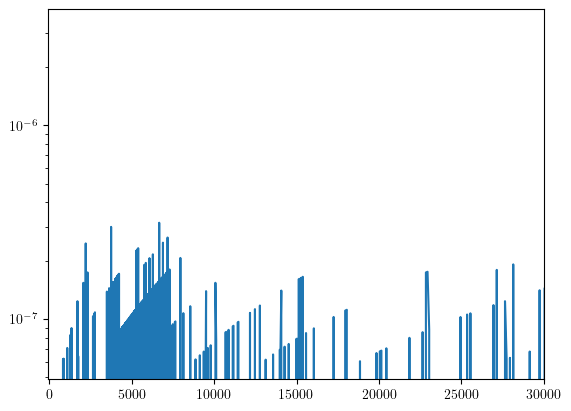

In [118]:
plt.plot(jnp.array(spec_df['wave']), (smc_jax - smc)/smc)
plt.xlim(-100, 30000)
plt.yscale('log')

# LMC

In [119]:

def lmc(wave, tau_v=1, **kwargs):
    """ Pei 1992 LMC extinction curve.

    :param wave:
        The wavelengths at which optical depth estimates are desired.

    :param tau_v: (default: 1)
        The optical depth at 5500\AA, used to normalize the
        attenuation curve.

    :returns tau:
        The optical depth at each wavelength.
    """
    if (wave < 1e3).any():
        warnings.warn('LMC: extinction extrapolation below 1000AA is poor')
    mic = wave * 1e-4
    aa = [175.,  19.,  0.023, 0.005, 0.006, 0.020]
    ll = [0.046, 0.08, 0.22,  9.7,   18.,   25.]
    bb = [90.,   5.50, -1.95, -1.95, -1.80, 0.00]
    nn = [2.0,   4.5,  2.0,   2.0,   2.0,   2.0]

    abs_ab = mic * 0.
    norm_v = 0  # hack to go from tau_b to tau_v
    mic_5500 = 5500 * 1e-4

    for i, a in enumerate(aa):
        norm_v += aa[i] / ((mic_5500 / ll[i])**nn[i] +
                           (ll[i] / mic_5500)**nn[i] + bb[i])
        abs_ab += aa[i] / ((mic / ll[i])**nn[i] + (ll[i] / mic)**nn[i] + bb[i])

    return tau_v * (abs_ab / norm_v)


def lmc_jax(wave, tau_v=1.0, **kwargs):
    """Pei (1992) LMC extinction curve.

    :param wave: Wavelengths in Ångström
    :param tau_v: Optical depth at 5500 Å
    :returns: Optical depth τ(λ)
    """
    mic = wave * 1e-4  # Convert to microns
    aa = jnp.array([175., 19., 0.023, 0.005, 0.006, 0.020])
    ll = jnp.array([0.046, 0.08, 0.22, 9.7, 18., 25.])
    bb = jnp.array([90., 5.50, -1.95, -1.95, -1.80, 0.00])
    nn = jnp.array([2.0, 4.5, 2.0, 2.0, 2.0, 2.0])

    abs_ab = jnp.zeros_like(mic)
    norm_v = 0.0
    mic_5500 = 5500.0 * 1e-4  # 5500 Å in microns

    for i in range(len(aa)):
        norm_term = aa[i] / ((mic_5500 / ll[i])**nn[i] + (ll[i] / mic_5500)**nn[i] + bb[i])
        abs_term = aa[i] / ((mic / ll[i])**nn[i] + (ll[i] / mic)**nn[i] + bb[i])
        norm_v += norm_term
        abs_ab += abs_term

    return tau_v * (abs_ab / norm_v)


In [120]:
lmc_jax = lmc_jax(wave=jnp.array(spec_df['wave']))
lmc = lmc(wave=np.array(spec_df['wave']))


/var/folders/vd/kv9mg1cx6tdfwmlfx2m5qfr80000gp/T/ipykernel_92271/1647767050.py:15: UserWarning: LMC: extinction extrapolation below 1000AA is poor
  warnings.warn('LMC: extinction extrapolation below 1000AA is poor')


(-100.0, 30000.0)

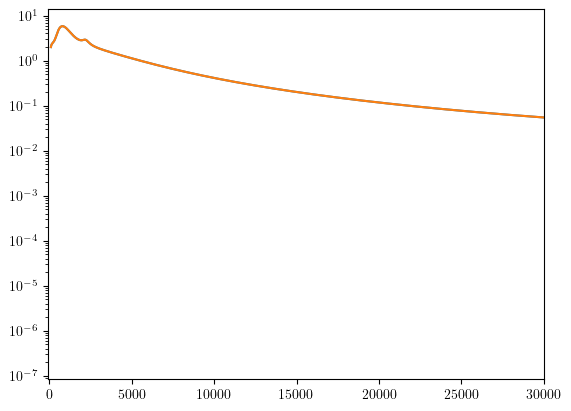

In [121]:
plt.plot(jnp.array(spec_df['wave']), lmc_jax)
plt.plot(jnp.array(spec_df['wave']), lmc)
plt.yscale('log')
plt.xlim(-100, 30000)

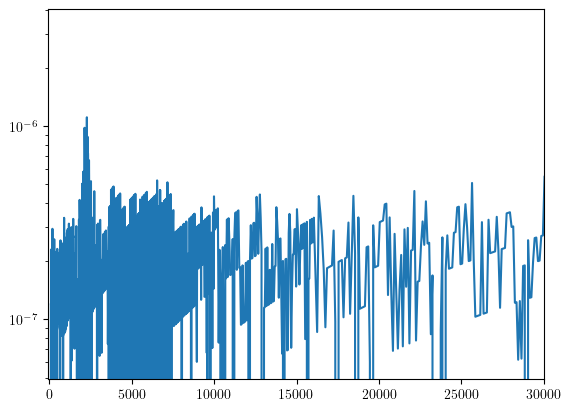

In [122]:
plt.plot(jnp.array(spec_df['wave']), (lmc_jax - lmc)/lmc)
plt.xlim(-100, 30000)
plt.yscale('log')